# 2. Transform and load to PyTorch

We need to create a dataset and loader that will handle NIfTI files since PyTorch doesn’t natively support the NIfTI file format. Additionally, because the images will be too large to fit into GPU memory, we’ll need to create a function to extract patches from the images. In this milestone we’ll create both.

## Background

PyTorch is a great library with support for a ton of options that help deep learning practitioners and researchers create and train models quickly. But it doesn't have built-in support for all data types, so we will need to build a method to load in our NIfTI files. Additionally, the memory on a GPU is usually too small to hold the whole dataset—especially with medical images. Consequently, we will also need to create a function that extracts a patch, i.e., a subset of the image, from both the source and target images at the same location.

In [4]:
import os
import glob
import nibabel as nib
import numpy as np
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms


class NiftiDataset(Dataset):
    def __init__(self, source_dir, target_dir, transforms=None):
        """
        Args:
            source_dir (string): Directory with all source Nifti images (T1)
            target_folder (string): Directory with all target Nifti images (T2)
            transform(callable, optional): Optinal transform to be applied on a sample
        """
        
        source_filenames = glob.glob(os.path.join(source_dir, '*.nii.gz'))
        target_filenames = glob.glob(os.path.join(target_dir, '*.nii.gz'))
        
        assert len(source_filenames)==len(target_filenames)
        # Here we simply assumed that pairs of images are in the same order when 
        #   sorted alphabetically
        # Works here, but probably need to match filename patterns with regexp
        # Or check dimensions, etc
        
        self.pairs = list(zip(source_filenames, target_filenames))
        self.transforms = transforms

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_names = self.pairs[idx]
        source_image = nib.load(img_names[0])
        target_image = nib.load(img_names[1])
        sample = {'source': source_image, 'target': target_image}

        # Do transforms on original Nibabel objects
        if self.transforms:
            sample = self.transforms(sample)
        
        return sample


class ToNumpy:
    """Convert Nibabel object in sample to ndarrays."""
    def __call__(self, sample):
        return {'source': sample['source'].get_fdata(),
                'target': sample['target'].get_fdata()}
        

class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return {'source': torch.from_numpy(sample['source'].get_fdata()),
                'target': torch.from_numpy(sample['target'].get_fdata())}
    

class RandomCrop3D:
    def __init__(self, size):
        """
        Args:
            size: integer or tuple of three numbers 
                    (x,y,z) to crop 3D images to
        """
        assert isinstance(size, (int,tuple))
        if isinstance(size, int):
            self.size = (size, size, size)
        else:
            assert len(size) == 3
            self.size = size

    def __call__(self, sample):
        """
        Utilize Nibabel's image slicing to save memory
        Note: That will prevent call from working directly
        Reference: https://nipy.org/nibabel/nibabel_images.html#image-slicing
        """
        source_image, target_image = sample['source'], sample['target']
        
        dim_x, dim_y, dim_z = source_image.shape[:3]
        new_dim_x, new_dim_y, new_dim_z = self.size
        
        # Generate random offset such that cropped image fits inside original one
        offset_x = np.random.randint(0, dim_x - new_dim_x)
        offset_y = np.random.randint(0, dim_y - new_dim_y)
        offset_z = np.random.randint(0, dim_z - new_dim_z)
        
        return {'source': source_image.slicer[offset_x: offset_x+new_dim_x,
                                              offset_y: offset_y+new_dim_y,
                                              offset_z: offset_z+new_dim_z],
                'target': target_image.slicer[offset_x: offset_x+new_dim_x,
                                              offset_y: offset_y+new_dim_y,
                                              offset_z: offset_z+new_dim_z]}

### Create transformed Dataset with `RandomCrop3D` transformation

In [6]:
transformed_brain_dataset = NiftiDataset(source_dir='small/t1', 
                                         target_dir='small/t2', 
                                         transforms=transforms.Compose(
                                             [RandomCrop3D((30,30,30)), 
                                              ToNumpy()])
                                        )

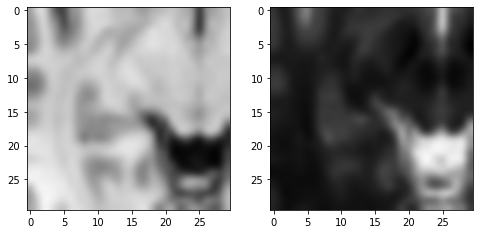

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Slice index
sl = 15   #Range: 0-30
sample = transformed_brain_dataset[2]

fig=plt.figure(figsize=(8, 8))

fig.add_subplot(1, 2, 1)
plt.imshow(sample['source'][:,sl,:], cmap="gist_gray", interpolation="bicubic")

fig.add_subplot(1, 2, 2)
plt.imshow(sample['target'][:,sl,:], cmap="gist_gray", interpolation="bicubic")
    
plt.show()